In [ ]:
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
import numpy.ma as ma

from scipy.ndimage.morphology import binary_dilation

import pcraster as pcr

pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [10]:
!unzip ../data/SRTM/SRTM_30_Asia_4060086180.zip -d ../output/SRTM/

!gdal_translate -a_nodata 0 -of PCRaster -ot Float32 ../output/SRTM/SRTM_30_Asia_4060086180.elevation.tif ../output/SRTM/SRTM_30_Asia_4060086180.elevation.map



Input file size is 17112, 6944
0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
path = r'../output/SRTM/SRTM_30_Asia_4060086180.elevation.map'

In [18]:
xmin=3000
xmax=6000
ymin=3000
ymax=6000

In [19]:
dem = pcr.readmap(path)

(6944, 17112)


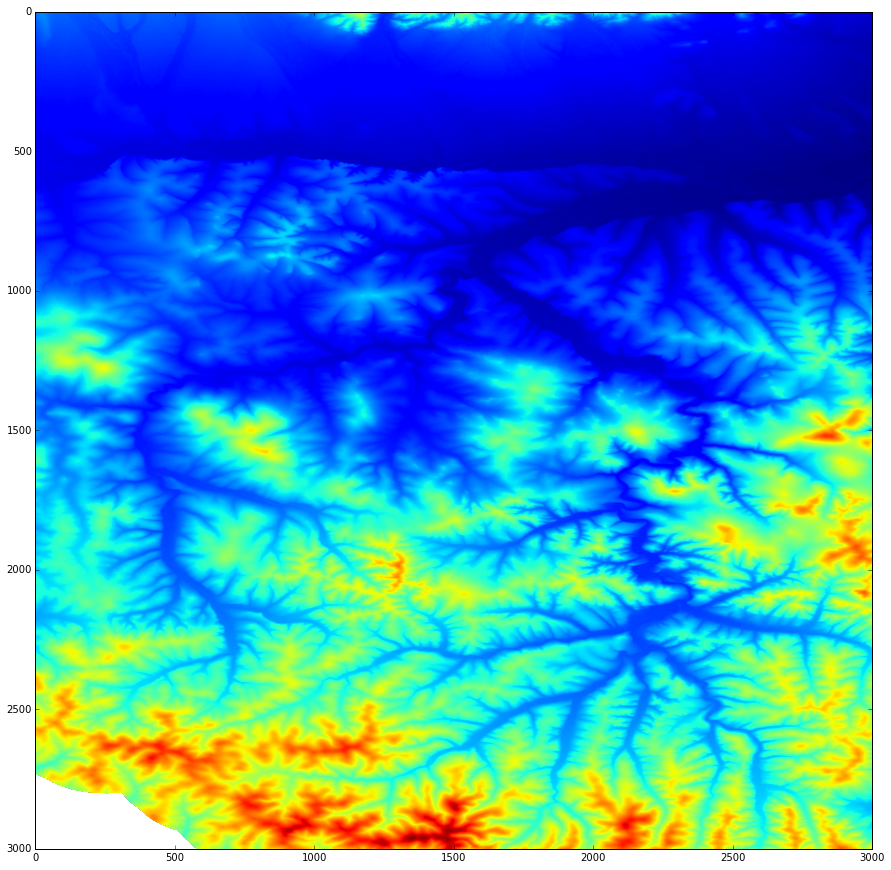

In [20]:
dem_np = pcr.pcr_as_numpy(dem)
print(dem_np.shape)
plt.imshow(dem_np[xmin:xmax, ymin:ymax])

In [21]:
# TODO: convert to meter!

slope = pcr.slope(dem)
pcr.report(slope, path[:-4] + '_slope.map')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


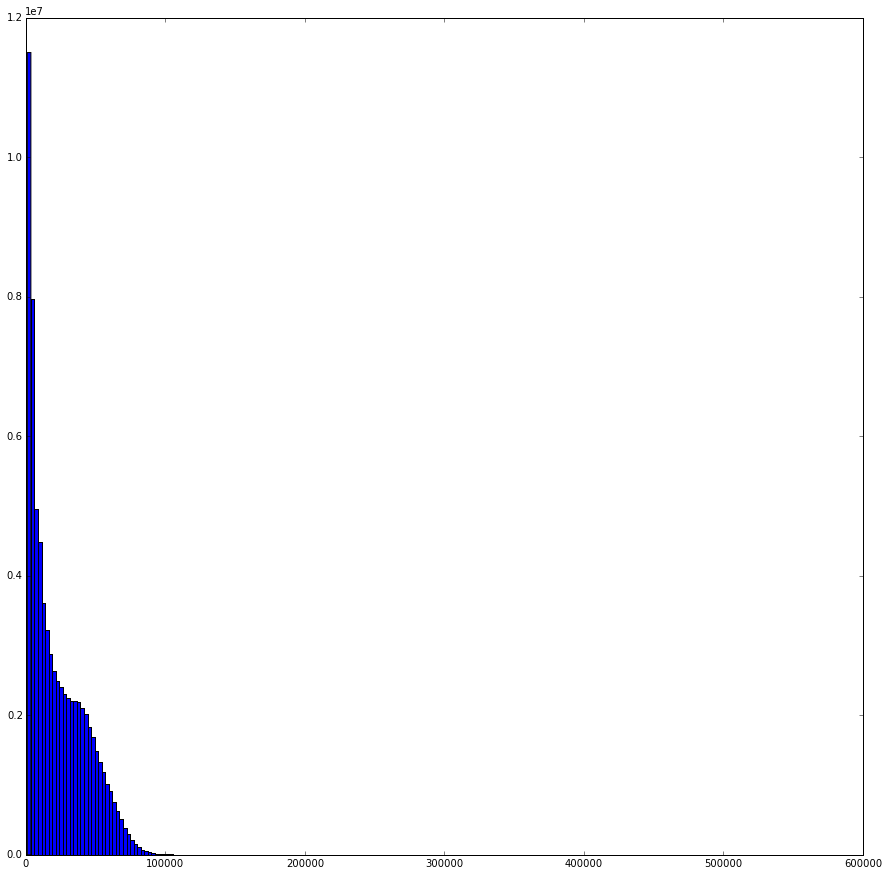

In [22]:
slope_np = pcr.pcr_as_numpy(slope)

_ = plt.hist(slope_np[slope_np>1000], bins=200)

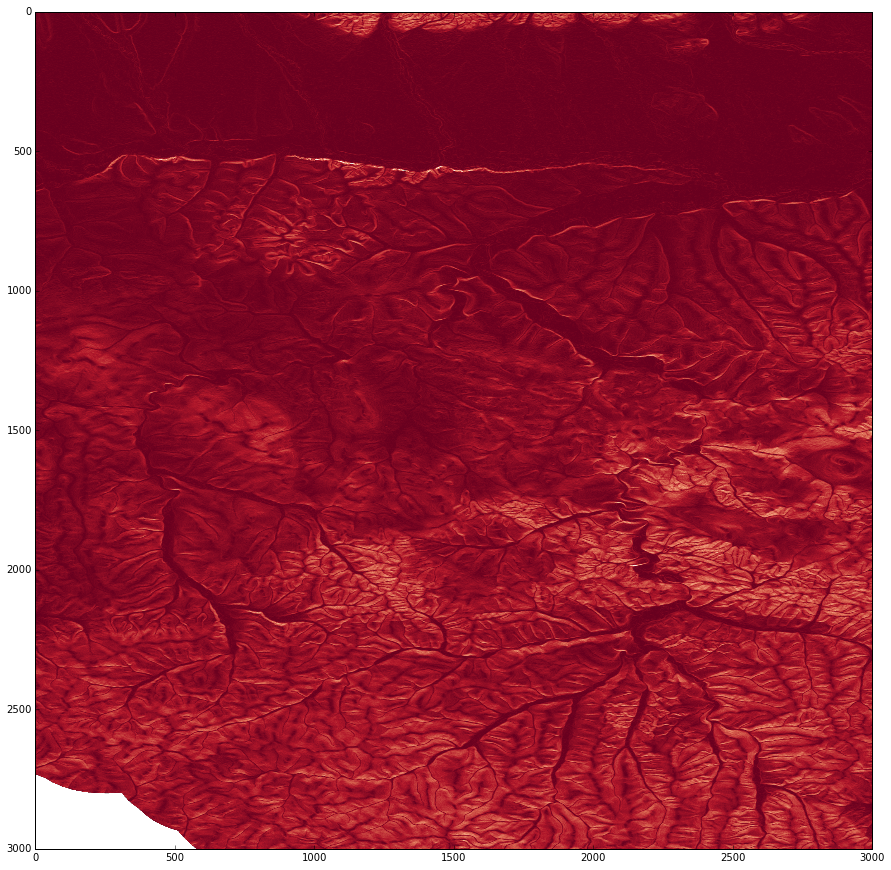

In [23]:
plt.imshow(slope_np[xmin:xmax, ymin:ymax], cmap='RdGy')

In [3]:
# enable pit filling
ldd = pcr.lddcreate(dem, 9999999, 9999999, 9999999, 9999999)
pcr.report(ldd, path[:-4] + '_ldd.map')

ldd_np = pcr.pcr_as_numpy(ldd)
ldd_np = ma.masked_equal(ldd_np, 255)

In [7]:
ldd = pcr.readmap(path[:-4] + '_ldd.map')

In [ ]:
dem_pitfilled = pcr.lddcreatedem(dem, 9999999, 9999999, 9999999, 9999999)
# dem_pitfilled = pcr.cover(dem_pitfilled, -100.0)
pcr.report(dem_pitfilled, path[:-4] + '_pitfilled_dem.map')

In [ ]:
# dem_pitfilled = pcr.readmap(path[:-4] + '_pitfilled_dem.map')

In [ ]:
dem_diff = dem_pitfilled - dem
pcr.report(dem_diff, path[:-4] + '_pitfilled_dem_diff.map')

dem_diff_np = pcr.pcr_as_numpy(dem_diff)
plt.imshow(dem_diff_np, cmap='Blues')

In [14]:
# check nodata values
from osgeo import gdal
ds = gdal.Open(path[:-4] + '_pitfilled_dem.map')
band1 = ds.GetRasterBand(1)
print(band1.GetNoDataValue())

-3.40282346639e+38


[[-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]
 ..., 
 [-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]]


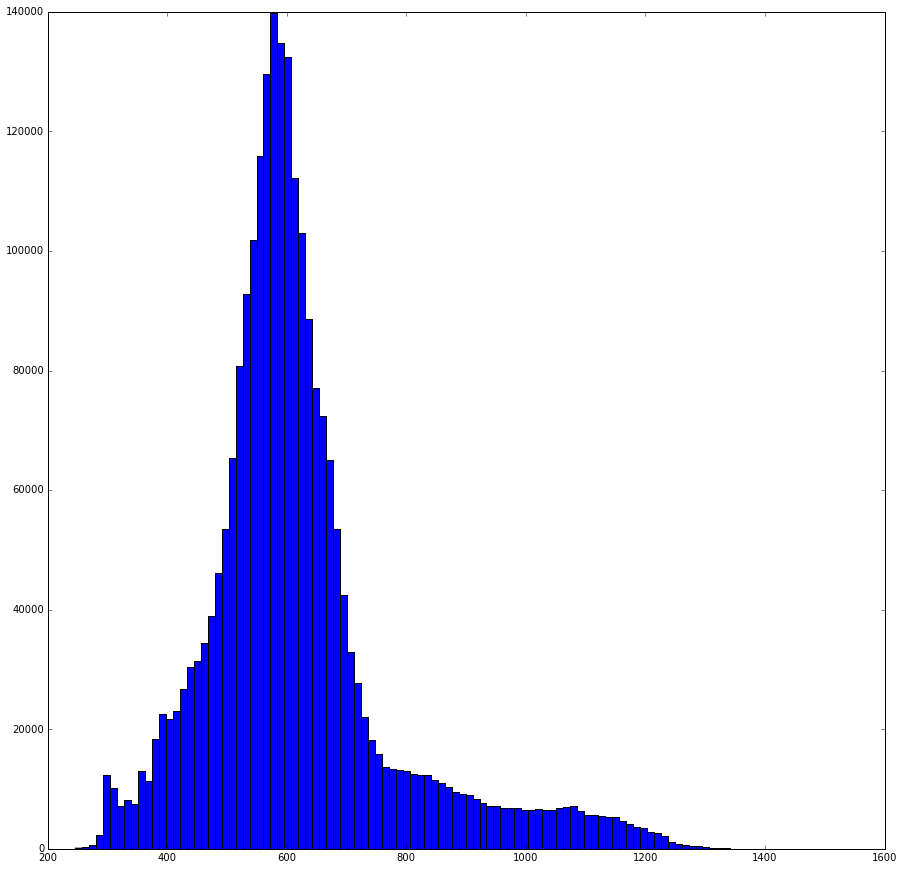

In [15]:
dem_pitfilled_np = pcr.pcr_as_numpy(dem_pitfilled)
from numpy import isnan
dem_pitfilled_np[isnan(dem_pitfilled_np)] = -100
print(dem_pitfilled_np)
_ = plt.hist(dem_pitfilled_np[dem_pitfilled_np > -100], bins=100)

In [16]:
# disable pit filling
ldd_pits = pcr.lddcreate(dem, 0, 0, 0, 0)

pcr.report(ldd_pits, path[:-4] + '_ldd_with_pits.map')

In [ ]:
# ldd_pits = pcr.readmap(path[:-4] + '_ldd_with_pits.map')

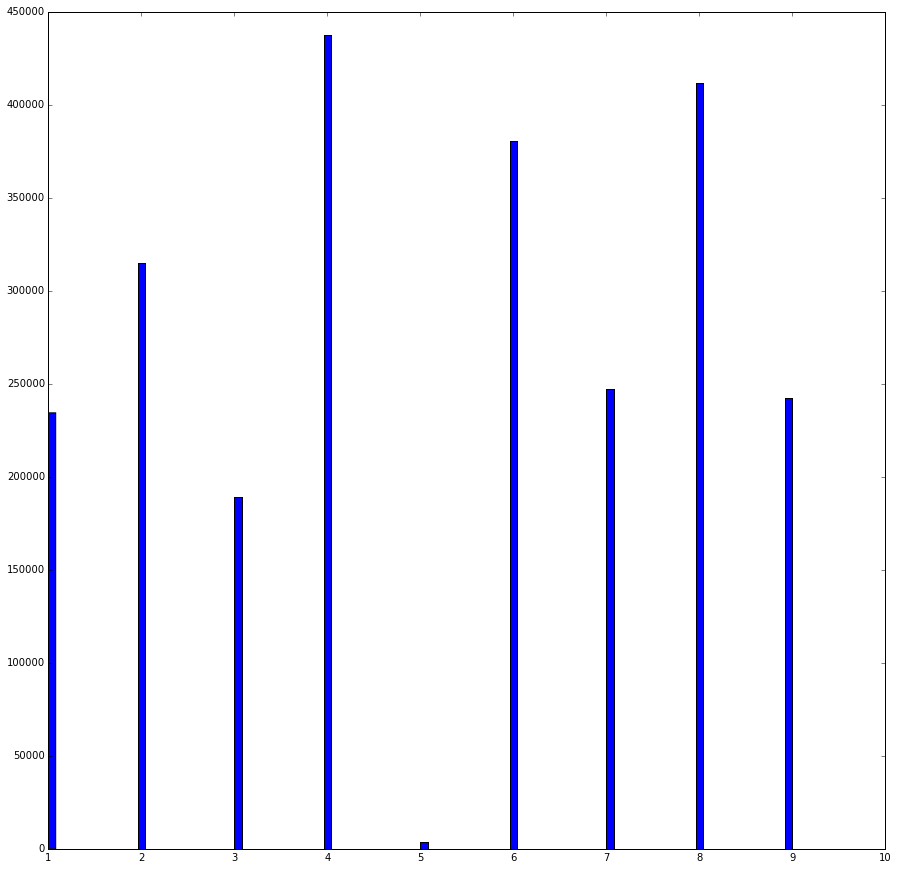

In [17]:
ldd_pits_np = pcr.pcr_as_numpy(ldd_pits)
ldd_pits_np = ma.masked_equal(ldd_pits_np, 255)

_ = plt.hist(ldd_pits_np[ldd_pits_np<10], bins=100)

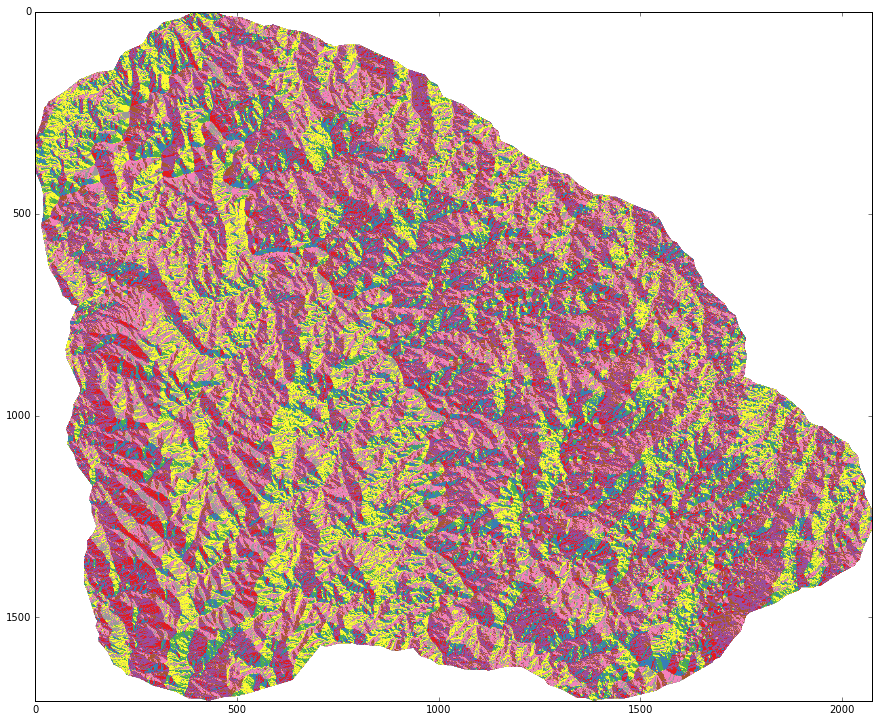

In [18]:
plt.imshow(ldd_pits_np[xmin:xmax, ymin:ymax], cmap='Set1')

3629


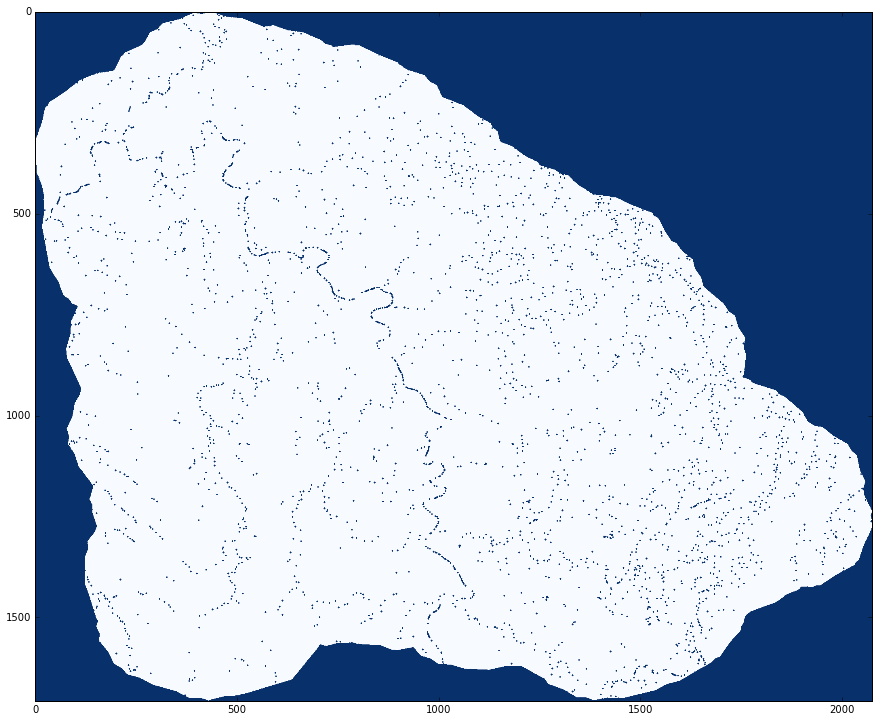

In [19]:
pits = pcr.pit(ldd_pits)

pcr.report(pits, path[:-4] + '_pits.map')

pits_np=pcr.pcr_as_numpy(pits)
pits_np=ma.masked_equal(pits_np, -2147483648)

print(len(pits_np[pits_np>0]))

# convert to binary image
dilated = binary_dilation(pits_np, iterations=2, mask=(pits_np >= 0))
plt.imshow(dilated[xmin:xmax, ymin:ymax], cmap='Blues')

In [5]:
catchments = pcr.catchment(ldd, pcr.pit(ldd))
pcr.report(catchments, path[:-4] + '_catchments.map')

In [ ]:
catchments_np = pcr.pcr_as_numpy(catchments)
catchments_np=ma.masked_equal(catchments_np, -2147483648)

print(catchments_np)
import matplotlib.colors
import numpy as np
cmap = matplotlib.colors.ListedColormap ( np.random.rand (len(catchments_np),3))
plt.imshow(catchments_np[xmin:xmax, ymin:ymax], cmap=cmap)

Create pits in the main river, see:

http://drm.cenn.org/Hazard_assessment_files/eng/Report_Flood%20Assessment%20in%20Georgia.pdf

In [ ]:
# ldd_pits = pcr.readmap(path[:-4] + '_ldd_with_pits.map')
# stream_order = pcr.readmap(path[:-4b] + '_streamorder.map')
# flowaccu = pcr.readmap(path[:-4] + '_flowaccu.map')

In [5]:
stream_order = pcr.streamorder(ldd)
stream_order_np = pcr.pcr_as_numpy(stream_order)
stream_order_np = ma.masked_equal(stream_order_np, -2147483648)
pcr.report(stream_order, path[:-4] + '_streamorder.map')

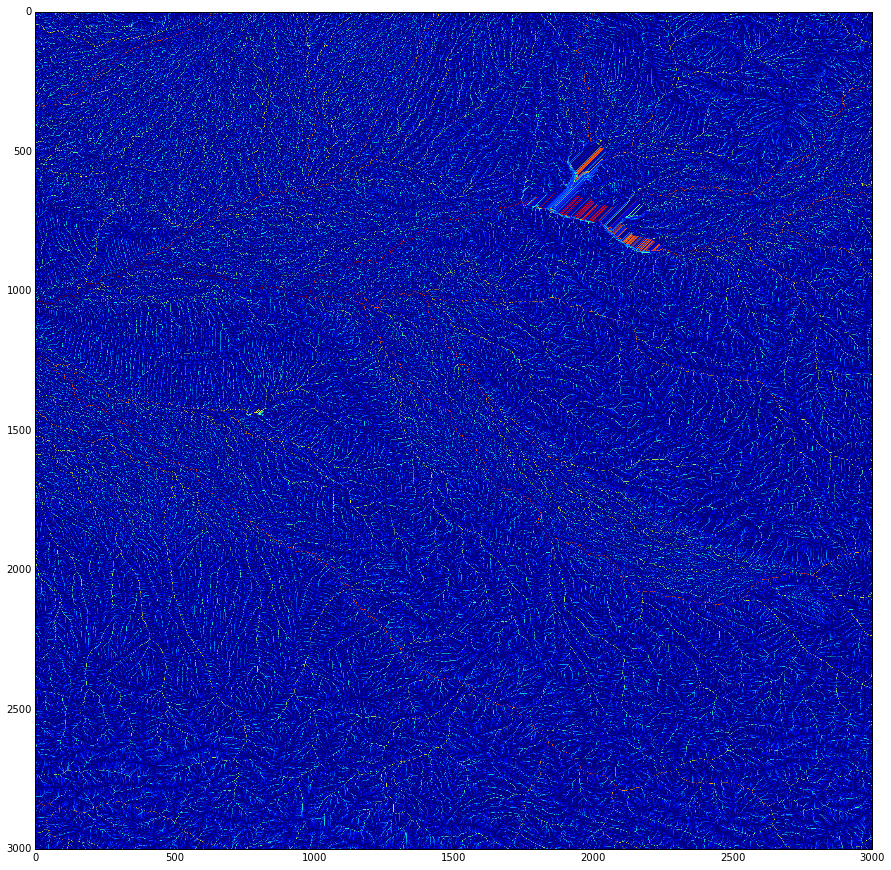

In [8]:
plt.imshow(stream_order_np[xmin:xmax, ymin:ymax])

In [9]:
flowaccu = pcr.accuflux(ldd, 1)
pcr.report(flowaccu, path[:-4] + '_flowaccu.map')

In [11]:
flowaccu = pcr.readmap(path[:-4] + '_flowaccu.map')

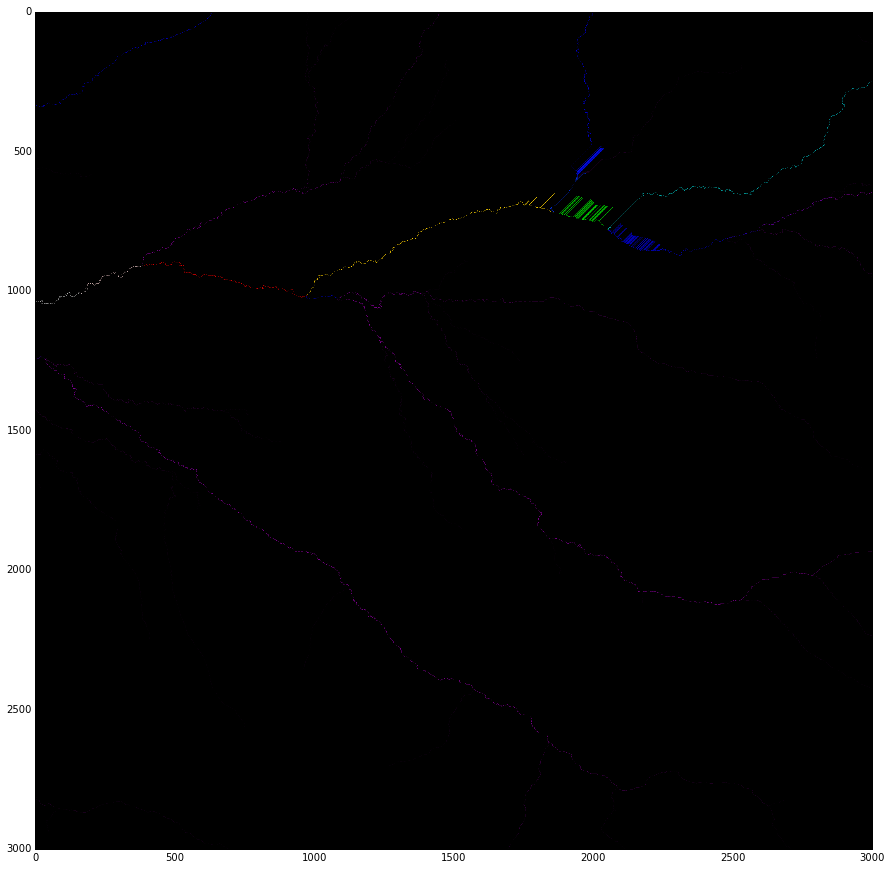

In [10]:
flowaccu_np = pcr.pcr_as_numpy(flowaccu)
plt.imshow(flowaccu_np[xmin:xmax, ymin:ymax], cmap='spectral')

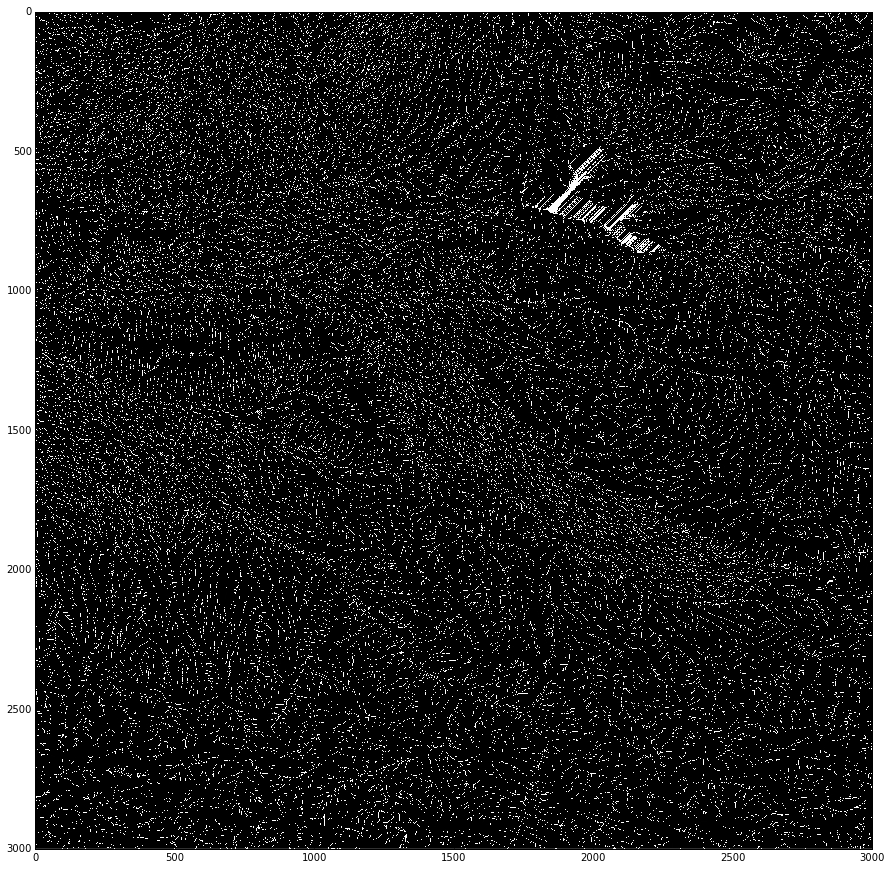

In [8]:
accuThreshold = 100
stream = pcr.ifthenelse(pcr.accuflux(ldd, 1) >= accuThreshold, pcr.boolean(1), pcr.boolean(0))

stream_np = pcr.pcr_as_numpy(stream)
stream_np = ma.masked_equal(stream_np, 255)

plt.imshow(stream_np[xmin:xmax, ymin:ymax], interpolation='none', cmap='gray')

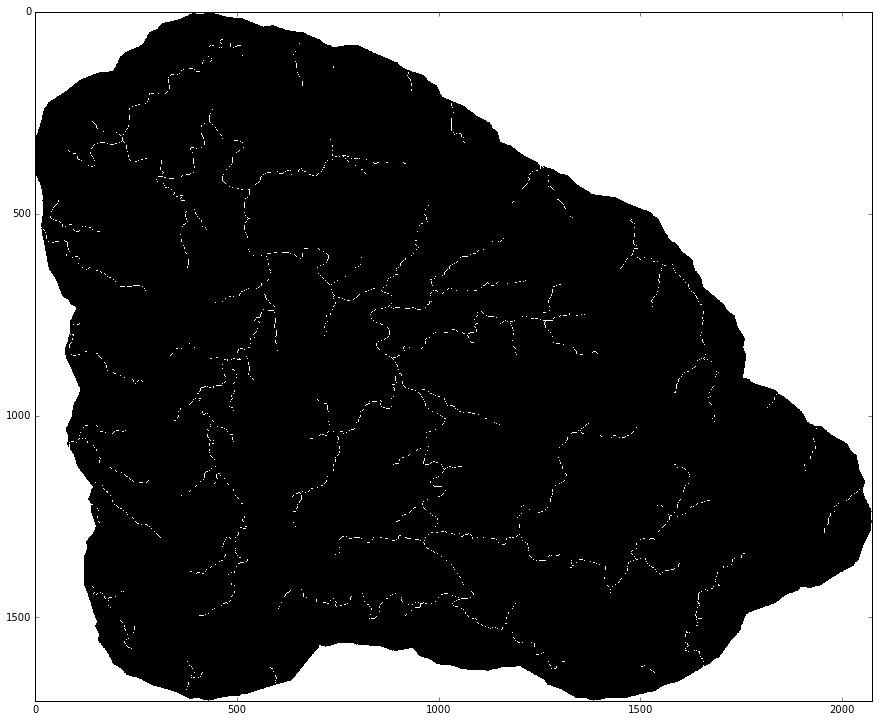

In [26]:
streamThr = 7
stream = pcr.ifthenelse(stream_order >= streamThr, pcr.boolean(1), pcr.boolean(0))

stream_np = pcr.pcr_as_numpy(stream)
stream_np = ma.masked_equal(stream_np, 255)

plt.imshow(stream_np, interpolation='none', cmap='gray')



In [12]:
height_river = pcr.ifthenelse(stream, pcr.ordinal(dem), 0)
up_elevation = pcr.scalar(pcr.subcatchment(ldd, height_river))

facc_river = pcr.ifthenelse(stream, pcr.ordinal(flowaccu), 0)
up_flowaccu = pcr.scalar(pcr.subcatchment(ldd, facc_river))

hand = pcr.max(dem-up_elevation, 0)
dist = pcr.ldddist(ldd, stream, 1)

MemoryError: 

In [ ]:
pcr.report(up_flowaccu, path[:-4] + '_faccand.map')
pcr.report(hand, path[:-4] + '_hand.map')
pcr.report(dist, path[:-4] + '_dist.map')

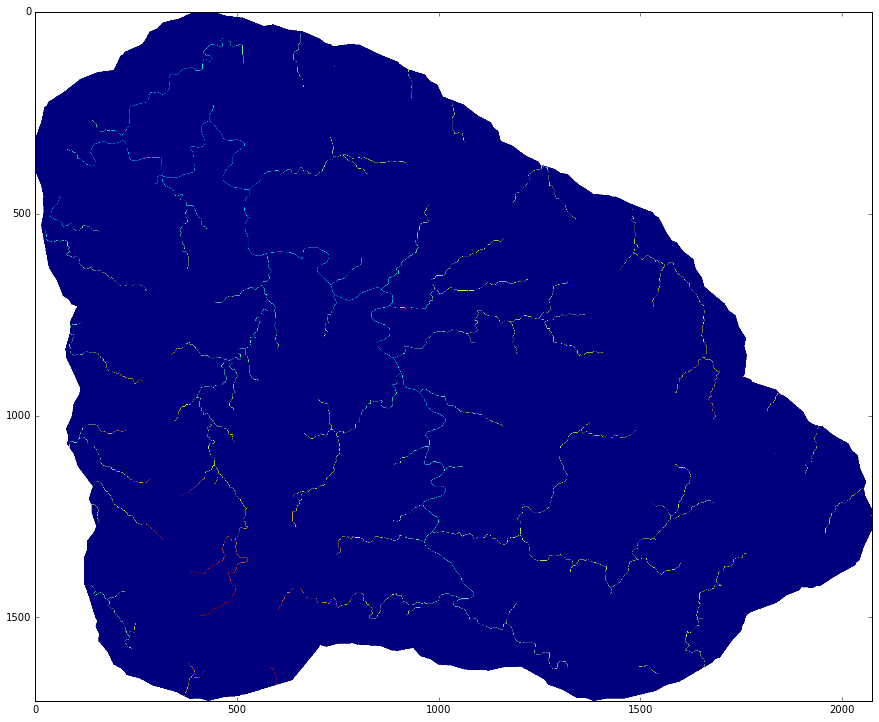

In [29]:
height_river_np = pcr.pcr_as_numpy(height_river)
height_river_np = ma.masked_equal(height_river_np, -2147483648)
plt.imshow(height_river_np)

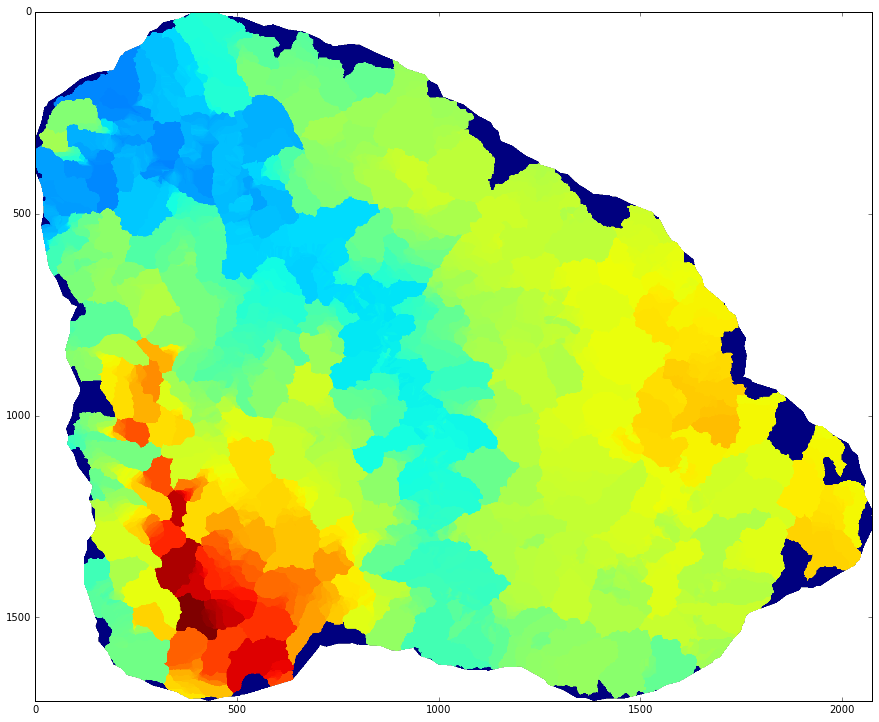

In [30]:
up_elevation_np = pcr.pcr_as_numpy(up_elevation)
plt.imshow(up_elevation_np)

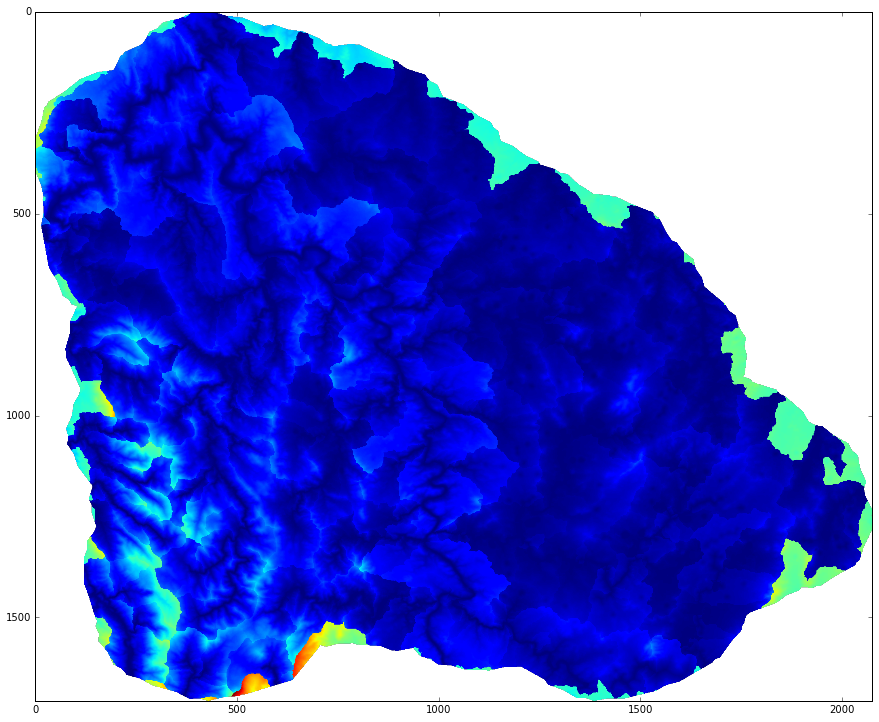

In [31]:
hand_np = pcr.pcr_as_numpy(hand)
plt.imshow(hand_np)

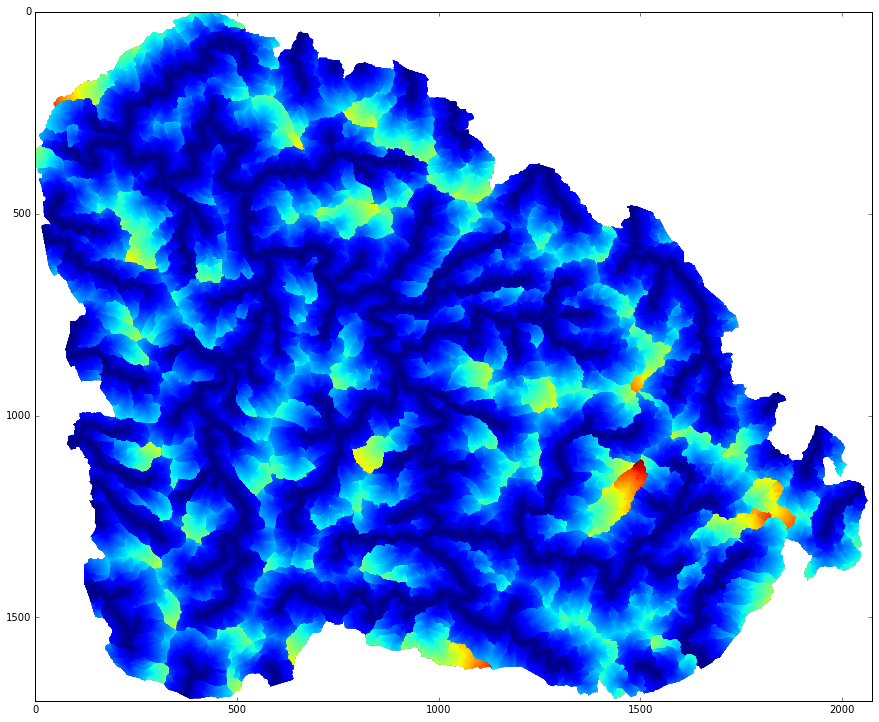

In [32]:
dist_np = pcr.pcr_as_numpy(dist)
plt.imshow(dist_np)

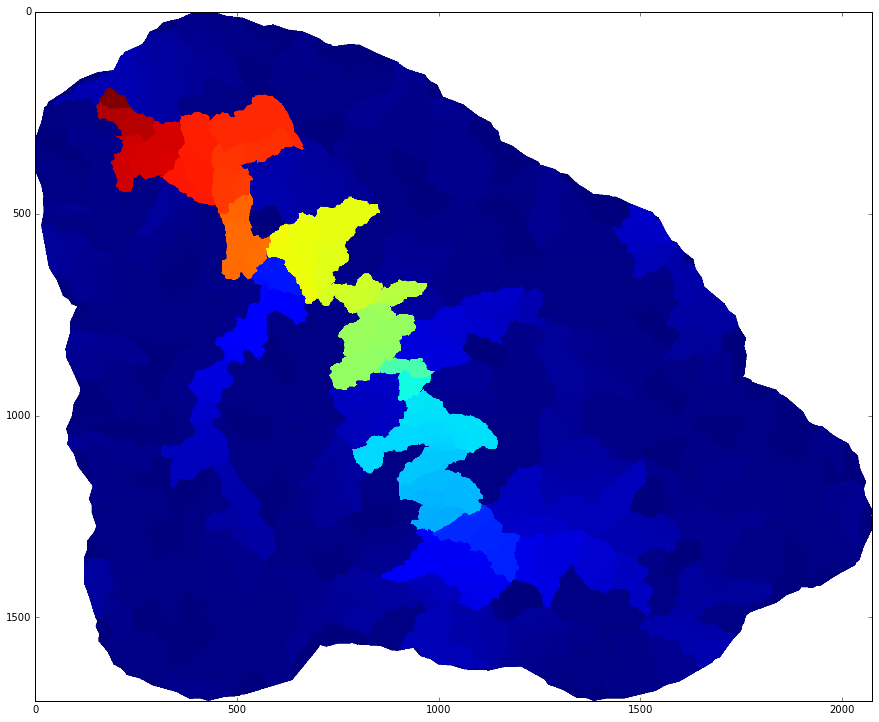

In [33]:
up_flowaccu_np = pcr.pcr_as_numpy(up_flowaccu)
plt.imshow(up_flowaccu_np)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


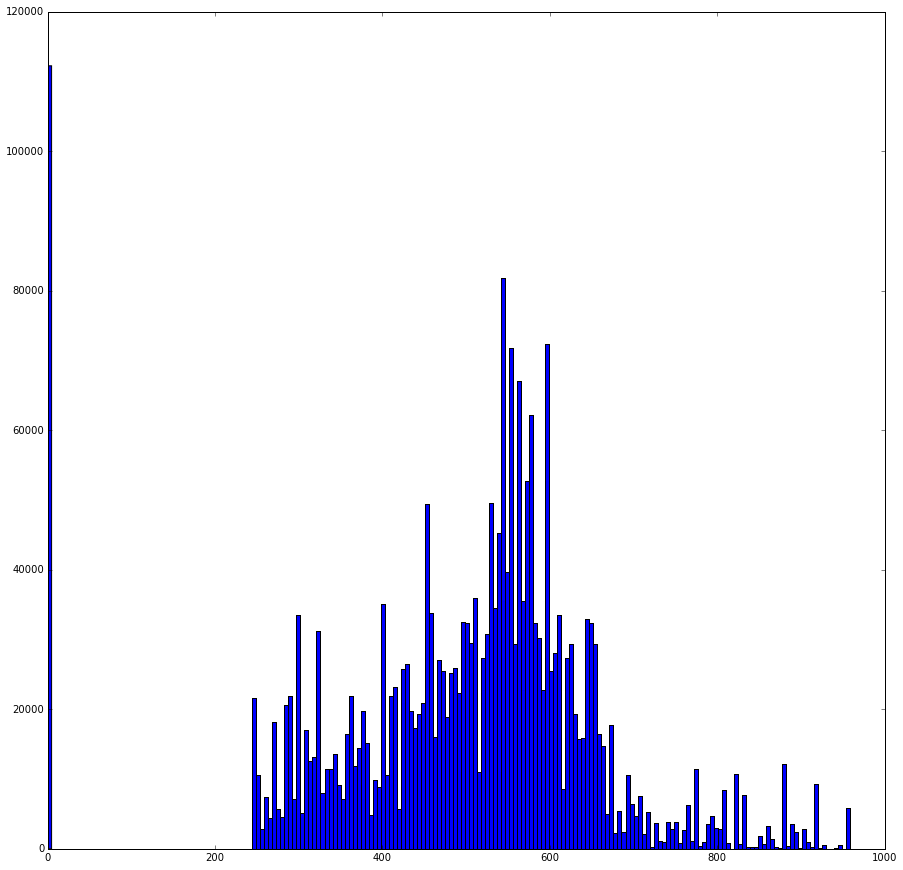

In [34]:
_ = plt.hist(up_elevation_np[up_elevation_np>-1], bins=200)

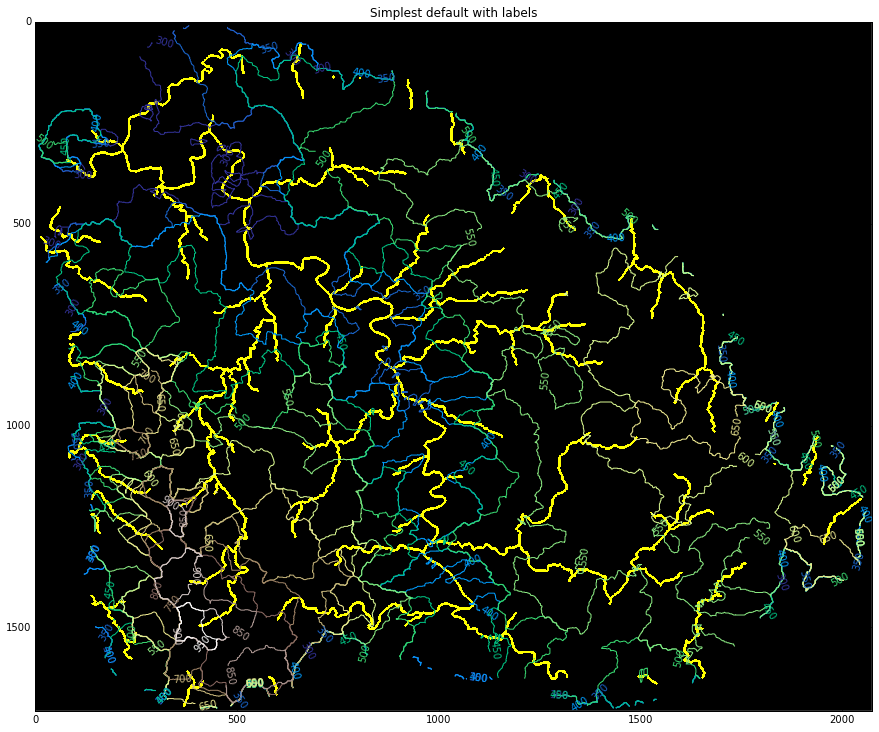

In [36]:
stream_order_np = pcr.pcr_as_numpy(stream_order)
stream_order_np = ma.masked_equal(stream_order_np, -2147483648)
stream_order_np_masked = ma.masked_less(stream_order_np, 10)

stream_order_np_masked[stream_order_np_masked<7]=0

iso = plt.contour(up_elevation_np, range(300,1000,50), cmap='terrain')
plt.clabel(iso, inline=1, fontsize=10, fmt='%.0f')
plt.title('Simplest default with labels')

dilated = binary_dilation(stream_order_np_masked, iterations=3)

# plt.imshow(stream_order_np_masked, interpolation='none')
# plt.imshow(dilated[0:500, 0:500], interpolation='none', cmap='binary')
plt.imshow(dilated, interpolation='none', cmap='gnuplot')